In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix, lil_matrix
from scipy import spatial
from scipy import stats

%matplotlib inline

In [2]:
data = pd.read_csv('C:/Users/prath/Downloads/proj_data.csv')
data.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
def count_na(data):
    na_count = pd.DataFrame(data.isnull().sum(), columns=['Count']).sort_values(by=['Count'], ascending=False)
    return na_count

In [5]:
count_na(data)

,Count
CustomerID,135080
Description,1454
InvoiceNo,0
StockCode,0
Quantity,0
InvoiceDate,0
UnitPrice,0
Country,0


In [6]:
data.InvoiceDate = pd.to_datetime(data.InvoiceDate, format="%m/%d/%Y %H:%M")
data["CustomerID"] = data["CustomerID"].fillna(-9999)
data["CustomerID"] = data["CustomerID"].apply(lambda x: str(x)[:-2])
data["Description"] = data["Description"].fillna("Unknown")

In [7]:
count_na(data)

,Count
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [8]:
data.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


### Deal with outliers

In [9]:
print(data.shape)

data = data[ np.abs((data['UnitPrice']-data['UnitPrice'].mean())/data['UnitPrice'].std()) <= 3]
data = data[ np.abs((data['Quantity']-data['Quantity'].mean())/data['Quantity'].std()) <= 3]

data = data[data["UnitPrice"] >= 0 ]
data = data[data["InvoiceNo"].astype(str).str[0] != "C"]
data = data[data["InvoiceNo"].astype(str).str[0] != "A"]
data = data[data["Quantity"] > 0 ]

print(data.shape)

(541909, 8)
(530795, 8)


In [10]:
data.describe()

,Quantity,UnitPrice
count,530795.000000,530795.000000
mean,9.765493,3.472191
std,25.387942,6.961868
min,1.000000,0.000000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,660.000000,293.000000


In [11]:
data['Revenue'] = data['Quantity']*data['UnitPrice']

data['Date'] = data['InvoiceDate'].dt.date
data['Day'] = data['InvoiceDate'].dt.day
data['Month'] = data['InvoiceDate'].dt.month
data['Year'] = data['InvoiceDate'].dt.year
data['Hour'] = data['InvoiceDate'].dt.hour
data['Week'] = data['InvoiceDate'].dt.week
data['Minute'] = data['InvoiceDate'].dt.minute

In [12]:
data.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Date,Day,Month,Year,Hour,Week,Minute
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01,1,12,2010,8,48,26
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,1,12,2010,8,48,26
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01,1,12,2010,8,48,26
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,1,12,2010,8,48,26
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,1,12,2010,8,48,26
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,15.30,2010-12-01,1,12,2010,8,48,26
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,25.50,2010-12-01,1,12,2010,8,48,26
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,2010-12-01,1,12,2010,8,48,28
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,2010-12-01,1,12,2010,8,48,28
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,United Kingdom,54.08,2010-12-01,1,12,2010,8,48,34


## Historical Revenue

C:\Users\prath\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


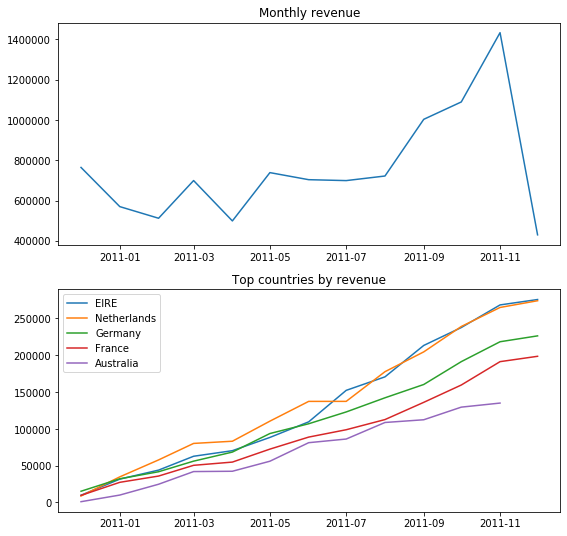

In [13]:
fig, ax = plt.subplots(2,1, figsize=(9, 9))

sales = data[['Year', 'Month', 'Revenue']].groupby(['Year', 'Month']).sum().reset_index()
sales['Day'] = 1
sales['Date'] = pd.to_datetime(sales[['Year', 'Month', 'Day']])
sales = sales.set_index('Date')
sales = sales.drop(['Year', 'Month', 'Day'], axis=1)

ax[0].plot(sales)
ax[0].set_title('Monthly revenue')

sales_top = data[['Revenue', 'Country']].groupby(['Country']).sum().reset_index().sort_values(by='Revenue', ascending=False)['Country'][1:6]

for c in sales_top:
    sales = data[data['Country'] == c]
    sales = sales[['Year', 'Month', 'Revenue']].groupby(['Year', 'Month']).sum().reset_index()
    sales['Day'] = 1
    sales['Date'] = pd.to_datetime(sales[['Year', 'Month', 'Day']])
    sales = sales.set_index('Date')
    sales = sales.drop(['Year', 'Month', 'Day'], axis=1)
    ax[1].plot(sales.cumsum(), label=c)    
    ax[1].legend()
    ax[1].set_title('Top countries by revenue')            
    
plt.show()

## Transaction amount time distribution

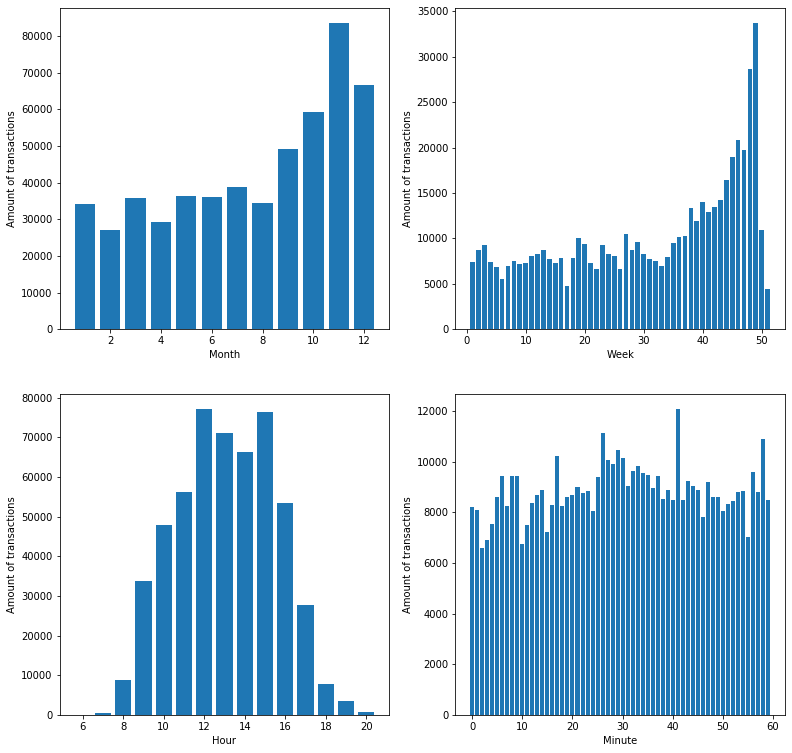

In [14]:
grps = np.array([['Month', 'Week'], ['Hour', 'Minute']])

fig, ax = plt.subplots(grps.shape[0],grps.shape[1], figsize=(13, 13))

for i in range(0, grps.shape[0]):
    for j in range(0, grps.shape[1]):
        grp_data = data[[grps[i,j], 'InvoiceNo']].groupby([grps[i,j]]).count()
        ax[i,j].bar(x=grp_data.index, height='InvoiceNo', data=grp_data)
        ax[i,j].set_ylabel('Amount of transactions')
        ax[i,j].set_xlabel(grps[i,j])
        
plt.show()

## Top selling products in different countries

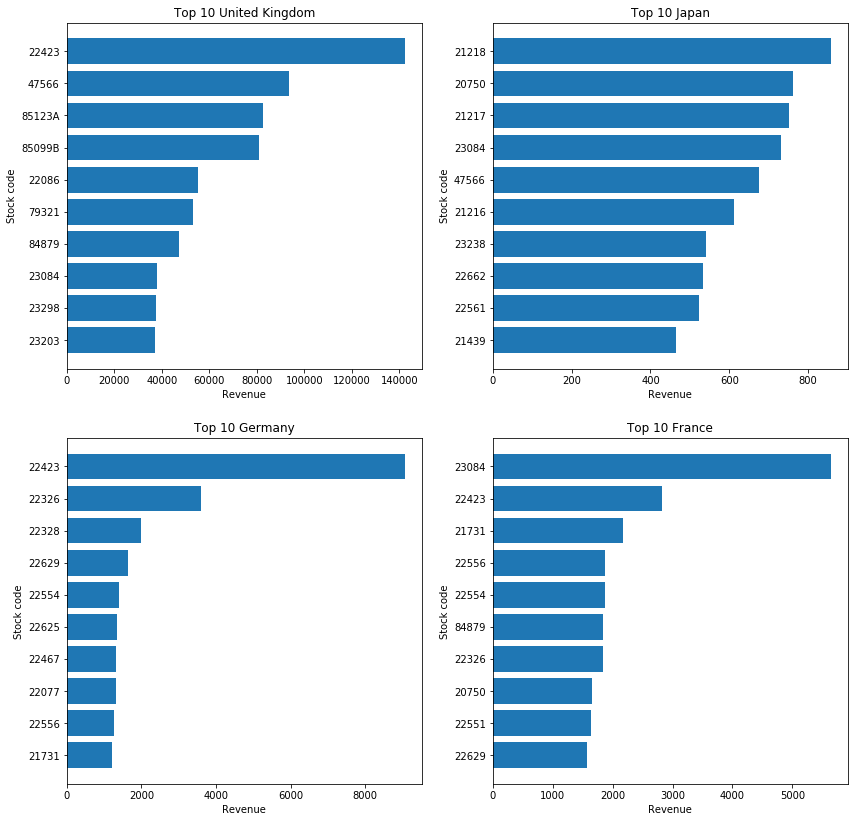

In [15]:
ctry = np.array([['United Kingdom', 'Japan'], ['Germany', 'France']])
fltr = ['DOT', 'POST', 'M']
top_n = 10

fig, ax = plt.subplots(grps.shape[0],grps.shape[1], figsize=(14, 14))

for i in range(0, ctry.shape[0]):
    for j in range(0, ctry.shape[1]):
        grp_data = data[data['Country'] == ctry[i,j]]
        grp_data = grp_data[~grp_data['StockCode'].isin(fltr)]
        grp_data = grp_data[['StockCode', 'Revenue']].groupby(['StockCode']).sum().sort_values(by='Revenue', ascending=False)        
        grp_data = grp_data[0:top_n]    
        grp_data = grp_data.reset_index()
        ax[i,j].barh(y=grp_data.index, width='Revenue', data=grp_data)
        ax[i,j].invert_yaxis()
        ax[i,j].set_yticks(range(0,top_n))
        ax[i,j].set_yticklabels(grp_data['StockCode'].tolist())
        ax[i,j].set_ylabel('Stock code')        
        ax[i,j].set_xlabel('Revenue')                
        ax[i,j].set_title('Top 10 ' + ctry[i,j])        
        
plt.show()

## Top selling products globally

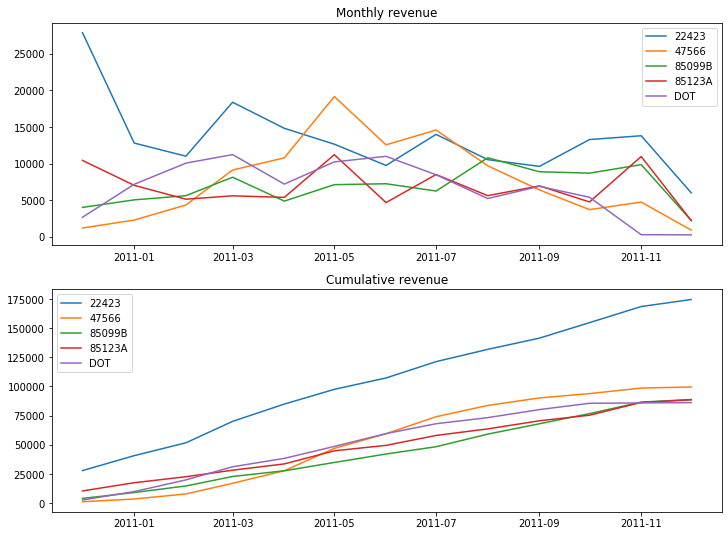

In [16]:
stock_top = data[['Revenue', 'StockCode']].groupby(['StockCode']).sum().reset_index().sort_values(by='Revenue', ascending=False)['StockCode'][0:5]

fig, ax = plt.subplots(2,1, figsize=(12, 9))

for c in stock_top:
    sales = data[data['StockCode'] == c]
    sales = sales[['Year', 'Month', 'Revenue']].groupby(['Year', 'Month']).sum().reset_index()
    sales['Day'] = 1
    sales['Date'] = pd.to_datetime(sales[['Year', 'Month', 'Day']])
    sales = sales.set_index('Date')
    sales = sales.drop(['Year', 'Month', 'Day'], axis=1)
    ax[0].plot(sales.Revenue, label=c)
    ax[0].legend()
    ax[0].set_title('Monthly revenue')
    
for c in stock_top:
    sales = data[data['StockCode'] == c]
    sales = sales[['Year', 'Month', 'Revenue']].groupby(['Year', 'Month']).sum().reset_index()
    sales['Day'] = 1
    sales['Date'] = pd.to_datetime(sales[['Year', 'Month', 'Day']])
    sales = sales.set_index('Date')
    sales = sales.drop(['Year', 'Month', 'Day'], axis=1)
    ax[1].plot(sales.cumsum(), label=c)
    ax[1].legend()
    ax[1].set_title('Cumulative revenue')   

<Figure size 432x288 with 0 Axes>

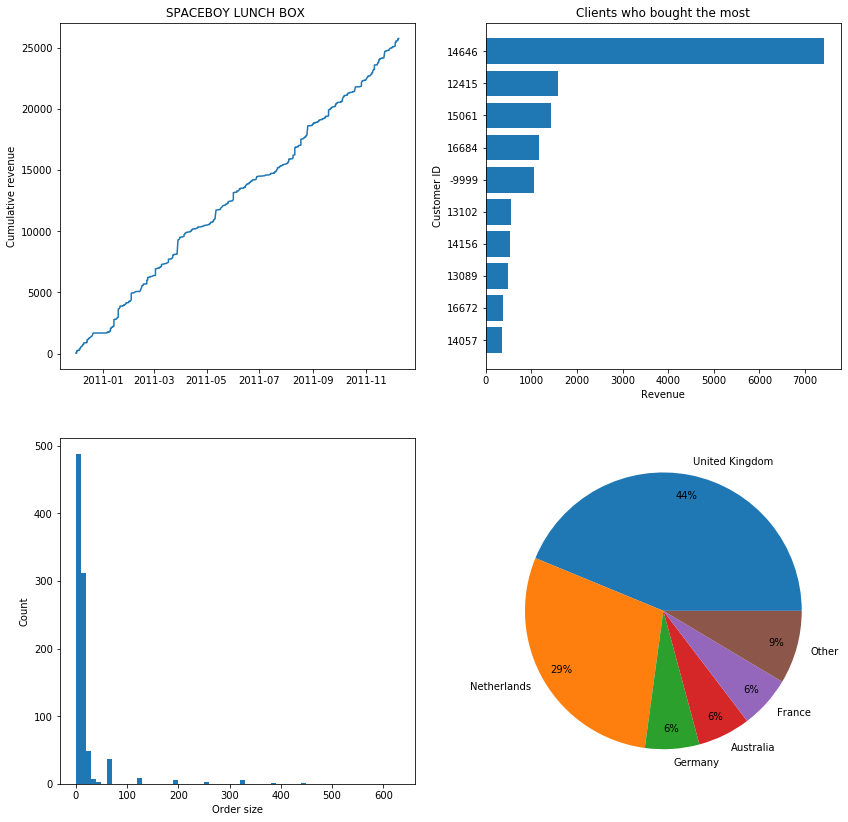

In [17]:
def top_stock(stockcode, top_n):
    """ Plot cumulative sales in pound sterling, 
    clients who bought the most, distribution of order size
    and pie chart with country % of buyers.    
    Parameters:
    stockcode: string with stock id
    top_n: how many bars etc to plot"""

    stock = data[data['StockCode'] == stockcode].sort_values(['InvoiceDate'])
    stock['ValueCum'] = stock['Revenue'].cumsum()

    top_buyers = stock[['Revenue', 'CustomerID']].groupby(['CustomerID']).sum().sort_values(by='Revenue', ascending=False).reset_index()
    top_buyers = top_buyers[0:top_n]

    ctry = stock[['Country', 'Revenue']].groupby(['Country']).sum().sort_values(by='Revenue', ascending=False)
    ctry = ((ctry/ctry.sum())*100).round(2)
    ctry = ctry[0:int(top_n/2)]
    ctry = ctry.append(pd.DataFrame(data=[100-ctry.sum()], columns=['Revenue'], index=['Other'] ))

    plt.clf()

    fig, ax = plt.subplots(grps.shape[0],grps.shape[1], figsize=(14, 14))
    
    ax[0,0].plot(stock['InvoiceDate'].dt.date, stock['ValueCum'])
    ax[0,0].set_ylabel('Cumulative revenue')        
    ax[0,0].set_title(stock['Description'].iloc[0])    

    ax[0,1].invert_yaxis()
    ax[0,1].barh(y=top_buyers.index, width='Revenue', data=top_buyers)
    ax[0,1].set_yticks(range(0,top_n))
    ax[0,1].set_yticklabels(top_buyers['CustomerID'].tolist())
    ax[0,1].set_ylabel('Customer ID')
    ax[0,1].set_xlabel('Revenue')      
    ax[0,1].set_title("Clients who bought the most")        

    ax[1,0].hist(stock['Quantity'], bins=range(0,stock['Quantity'].max(), top_n) )
    ax[1,0].set_ylabel('Count')        
    ax[1,0].set_xlabel('Order size')     

    ax[1,1].pie(ctry['Revenue'], labels=ctry.index,  autopct='%1.0f%%', pctdistance=0.85)

    plt.show()
    
top_stock(stockcode="22629", top_n = 10)

## Customer Stalking

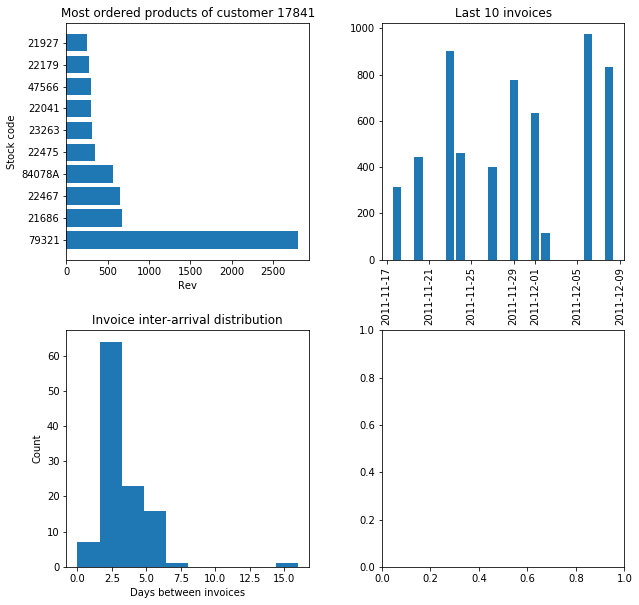

In [18]:
def stalk_customer(customer_id):        
    c_data = data[data['CustomerID'] == customer_id ]

    most_ordered = c_data[['StockCode', 'Revenue']].groupby(['StockCode']).sum().sort_values(by='Revenue', ascending=False)
    most_ordered = most_ordered[0:10]

    last_inv = c_data[['InvoiceNo', 'Revenue', 'Date']].groupby(['InvoiceNo', 'Date'], as_index='False').sum().sort_values(by='Revenue')
    last_inv = last_inv.reset_index()
    last_inv = last_inv.set_index('Date').sort_index(ascending=False)
    last_inv = last_inv[0:10]
    inv_diff = data[data['CustomerID'] == customer_id][['InvoiceNo', 'Revenue', 'Date']]
    inv_diff = inv_diff[['Revenue', 'Date']].groupby(['Date'], as_index=False).sum()
    inv_diff = inv_diff.sort_values(by='Date', ascending=False)
    inv_diff['DateDiff'] = (inv_diff['Date'] - inv_diff['Date'].shift(-1) ).dt.days
    inv_diff = inv_diff.fillna(0, axis=1)

    fig, ax = plt.subplots(2,2, figsize=(10, 10))

    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    ax[0,0].barh(y=most_ordered.index, width="Revenue", data=most_ordered)
    ax[0,0].set_ylabel('Stock code')        
    ax[0,0].set_xlabel('Rev')     
    ax[0,0].set_title('Most ordered products of customer ' + str(customer_id))
    ax[0,1].bar(x=last_inv.index, height='Revenue', data=last_inv)
    ax[0,1].set_title('Last 10 invoices')    

    ax[1,0].hist(inv_diff['DateDiff'])
    ax[1,0].set_ylabel('Count')        
    ax[1,0].set_xlabel('Days between invoices')     
    ax[1,0].set_title('Invoice inter-arrival distribution')    

    plt.sca(ax[0,1])
    plt.xticks(rotation=90)

    plt.show()
    
stalk_customer(customer_id = '17841')

## Building a customer table

In [19]:
def interarrival(cid):
    s = data[data['CustomerID'] == str(cid)].sort_values(by=['Date'])['Date']    
    x = (s - s.shift(1)).dropna()
    
    if x.empty:
        return 0
    
    else:
        return x.dt.days.mean()

In [20]:
c_data = data[['CustomerID', 'InvoiceDate']].groupby('CustomerID', as_index=False)['InvoiceDate'].min()
c_data.columns = ['CustomerID', 'i_first']

c_data['i_first'] = data[['CustomerID', 'InvoiceDate']].groupby('CustomerID', as_index=False)['InvoiceDate'].min()['InvoiceDate']
c_data['i_last'] = data[['CustomerID', 'InvoiceDate']].groupby('CustomerID', as_index=False)['InvoiceDate'].max()['InvoiceDate']

c_data['d_as_customer']  = (max(c_data['i_last']) - c_data['i_first']).dt.days
c_data['d_last_invoice']  = (max(c_data['i_last']) - c_data['i_last'] ).dt.days

c_data['i_last_30D']  = c_data['d_last_invoice'].apply(lambda x: 1 if x < 30 else 0)
c_data['i_last_90D']  = c_data['d_last_invoice'].apply(lambda x: 1 if x >= 30 and x < 90 else 0)
c_data['i_last_180D'] = c_data['d_last_invoice'].apply(lambda x: 1 if x >= 90 and x < 180 else 0)
c_data['i_over_180D'] = c_data['d_last_invoice'].apply(lambda x: 1 if x >= 180 else 0)

c_data['i_arrival_rate'] = c_data['CustomerID'].apply(interarrival)

c_data['t_invoices'] = data[['CustomerID', 'InvoiceDate']].groupby('CustomerID', as_index=False)['InvoiceDate'].count()['InvoiceDate']
c_data['t_units'] = data[['CustomerID', 'Quantity']].groupby('CustomerID', as_index=False)['Quantity'].sum()['Quantity']
c_data['t_rev'] = data[['CustomerID', 'Revenue']].groupby('CustomerID', as_index=False)['Revenue'].sum()['Revenue']

c_data['u_orders'] = data[['CustomerID', 'StockCode']].groupby('CustomerID', as_index=False).nunique()['StockCode']
c_data['pct_rev_total'] = (c_data['t_rev']/data['Revenue'].sum())*100
c_data['avg_rev'] = data[['CustomerID', 'Revenue']].groupby('CustomerID', as_index=False)['Revenue'].mean()['Revenue']

c_data['a_rate_week'] = c_data['i_arrival_rate'].apply(lambda x:  1 if x <  7  else 0)
c_data['a_rate_2week'] = c_data['i_arrival_rate'].apply(lambda x: 1 if x >= 7  and x < 14 else 0)
c_data['a_rate_month'] = c_data['i_arrival_rate'].apply(lambda x: 1 if x >= 14 and x < 30 else 0)
c_data['a_rate_small'] = c_data['i_arrival_rate'].apply(lambda x:  1 if x >= 30 else 0)

c_data = c_data[c_data['CustomerID'] != str(-9999)]

In [21]:
c_data.round(2).head()

,CustomerID,i_first,i_last,d_as_customer,d_last_invoice,i_last_30D,i_last_90D,i_last_180D,i_over_180D,i_arrival_rate,t_invoices,t_units,t_rev,u_orders,pct_rev_total,avg_rev,a_rate_week,a_rate_2week,a_rate_month,a_rate_small
1,12347,2010-12-07 14:57:00,2011-12-07 15:52:00,366,1,1,0,0,0,2.02,182,2458,4310.00,103,0.04,23.68,1,0,0,0
2,12348,2010-12-16 19:09:00,2011-09-25 13:13:00,357,74,0,1,0,0,9.43,31,2341,1797.24,22,0.02,57.98,0,1,0,0
3,12349,2011-11-21 09:51:00,2011-11-21 09:51:00,18,18,1,0,0,0,0.00,72,630,1457.55,72,0.01,20.24,1,0,0,0
4,12350,2011-02-02 16:01:00,2011-02-02 16:01:00,309,309,0,0,0,1,0.00,17,197,334.40,17,0.00,19.67,1,0,0,0
5,12352,2011-02-16 12:33:00,2011-11-03 14:37:00,296,35,0,1,0,0,3.13,84,535,2129.54,59,0.02,25.35,1,0,0,0


## Visualization

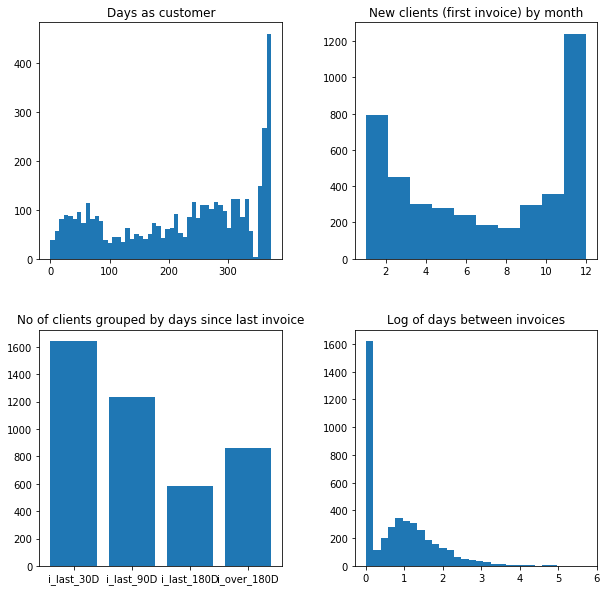

In [22]:
fig, ax = plt.subplots(2,2, figsize=(10, 10))

plt.subplots_adjust(hspace=0.3, wspace=0.3)

ax[0,0].hist(c_data['d_as_customer'], bins=50)
ax[0,0].set_title('Days as customer')        

ax[1,0].bar(x=['i_last_30D', 'i_last_90D', 'i_last_180D', 'i_over_180D'], height=c_data[['i_last_30D', 'i_last_90D', 'i_last_180D', 'i_over_180D']].sum())
ax[1,0].set_title('No of clients grouped by days since last invoice')        

ax[0,1].hist(c_data['i_first'].dt.month)
ax[0,1].set_title('New clients (first invoice) by month')        

ax[1,1].hist(c_data['i_arrival_rate'].apply(lambda x: np.log(x+1)), bins=30)
ax[1,1].set_title('Log of days between invoices')        


plt.show()

## Building multicriterial ranking

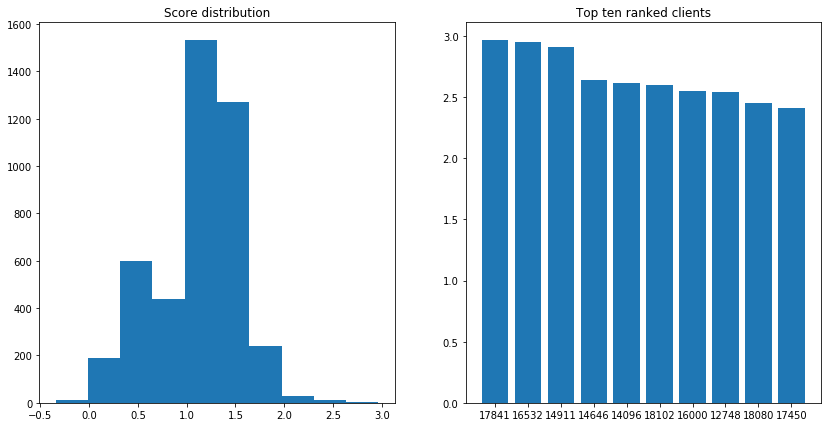

In [23]:
rk = c_data.copy()

rk['t_rev'] = rk['t_rev'].apply(lambda x: np.log(x))
rk['t_units'] = rk['t_units'].apply(lambda x: np.log(x))

cols = ['d_as_customer', 't_invoices', 't_rev', 't_units', 'avg_rev', 'i_arrival_rate']

for c in cols:
    rk.loc[:,str(c)] = rk[str(c)].apply(lambda x: (x-rk[str(c)].min())/(rk[str(c)].max()-rk[str(c)].min()))
    
rk['Active'] = (3*rk['i_last_30D'] + 2*rk['i_last_90D'] + rk['i_last_180D'] - 4*rk['i_over_180D'])/10
cols.append('Active')
cols.append('CustomerID')
rk = rk[cols]
rk['Score'] = rk.iloc[:,1:rk.shape[1]].sum(axis=1)
rk = rk.loc[:,['CustomerID', 'Score']]
rk = rk.sort_values(by=['Score'], ascending=False)
rk = rk.reset_index(drop=True)

fig, ax = plt.subplots(1,2, figsize=(14, 7))

ax[0].hist(rk['Score'].values)
ax[0].set_title('Score distribution')    

ax[1].bar(x=np.arange(10), height=rk['Score'][0:10])
ax[1].set_xticks(np.arange(10))
ax[1].set_xticklabels(rk['CustomerID'][0:10].tolist())
ax[1].set_title("Top ten ranked clients")    

plt.show()

In [ ]:
#### 